In [7]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
import numpy as np
import pickle,itertools
from sklearn.model_selection import train_test_split
plt.rcParams["figure.figsize"] = (10,7)

import pickle

import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
reg_class_1_val=xgb.Booster()
reg_class_1_val.load_model('./output/regressor_class1/positive_class_xgb_validation_regressor.json')

reg_class_0_val=xgb.Booster()
reg_class_0_val.load_model('./output/regressor_class0/negative_class_xgb_validation_regressor.json')

In [4]:
train_set = pd.read_csv('./data/train_df_expanded_KNN_imp_feats.csv')
train_set = train_set.replace([np.inf, -np.inf], np.nan)

with open("./output/classifier/y_train3_clf_preds.pkl", "rb") as f:
    y_val_class = pickle.load(f)



## Regressors: Combine both regressor's outputs

In [5]:
# Regressor class 1
y_train = train_set['Target']
x_train = train_set.drop(['Date', 'Target','Abs Target', 'Target > 2'], axis=1)
x_train = x_train[reg_class_1_val.feature_names ]

X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.15, shuffle=False)

X_test = X_test.iloc[5:]
y_test = y_test.iloc[5:]
X_test.columns=x_train.columns

X_train['Class']=y_val_class[:len(X_train)]
X_test['Class']=y_val_class[-len(X_test):]

dval = xgb.DMatrix(X_test[X_test['Class']==1].drop(columns=['Class']), y_test[X_test['Class']==1])
X_test['Target']=y_test
X_test['Prediction']=0
X_test['Prediction'][X_test['Class']==1]=reg_class_1_val.predict(dval)

# Regressor class 0
y_train0 = train_set['Target']
x_train0 = train_set.drop(['Date', 'Target','Abs Target', 'Target > 2'], axis=1)
x_train0 = x_train0[reg_class_0_val.feature_names]

X_train0, X_test0, y_train0, y_test0 = train_test_split(x_train0, y_train0, test_size=0.15, shuffle=False)

X_test0.columns = x_train0.columns

X_test0 = X_test0.iloc[5:]
y_test0 = y_test0.iloc[5:]

X_test0['Class']=y_val_class[-len(X_test0):]

X_test0=xgb.DMatrix(X_test0[X_test0['Class']==0].drop(columns=['Class']))
X_test['Prediction'][X_test['Class']==0]=reg_class_0_val.predict(X_test0)

# Combined RMSE
rmse = np.sqrt(mean_squared_error(X_test['Target'], X_test['Prediction']))
rmse

1.2287713849144064

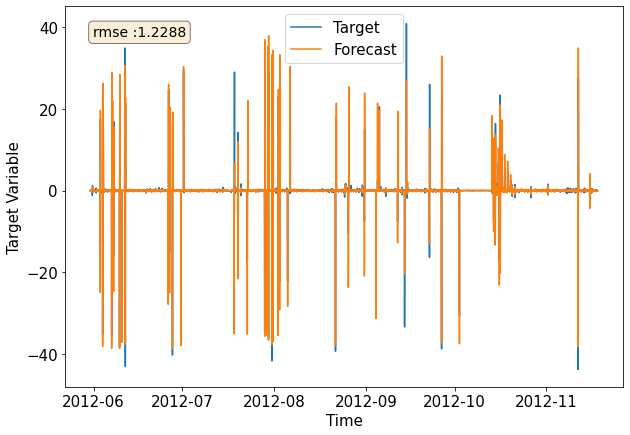

In [8]:
train_set['Date']=pd.to_datetime(train_set['Date'])
# plot the forecasted values against the real values
plt.plot(train_set['Date'][len(X_train)+5:], X_test['Target'], label='Target')
plt.plot(train_set['Date'][len(X_train)+5:], X_test['Prediction'], label='Forecast')
textstr = 'rmse :' + str(rmse.round(4)) 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=props)
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.rcParams.update({'font.size': 15})
plt.legend()
plt.show()

In [9]:
MAPE_class_1=mean_absolute_percentage_error(y_test[X_test['Class']==1], reg_class_1_val.predict(dval), sample_weight=np.abs(y_test[X_test['Class']==1])/sum(np.abs(y_test[X_test['Class']==1])))
MAPE_class_1

0.28712292959431274

In [10]:
rmse_class_1 = np.sqrt(mean_squared_error( y_test[X_test['Class']==1], reg_class_1_val.predict(dval)))
rmse_class_1

6.4895199597284625

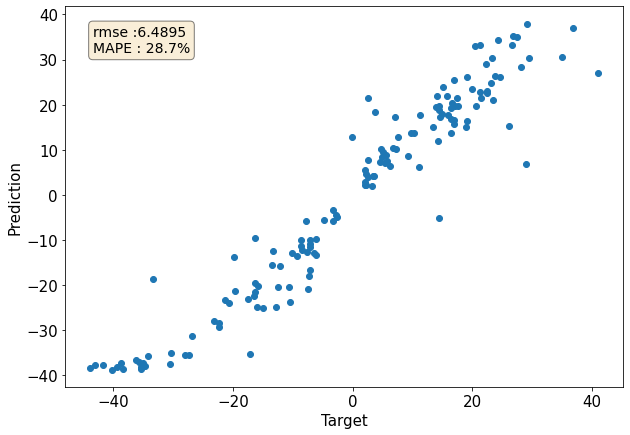

In [11]:
plt.scatter(X_test[X_test['Class']==1]['Target'], X_test[X_test['Class']==1]['Prediction'])
textstr = 'rmse :' + str(rmse_class_1.round(4)) +'\n' + 'MAPE : ' + str(100*MAPE_class_1.round(3)) +'%'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=props)
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.rcParams.update({'font.size': 15})
plt.show()

## Compute on testing test

In [13]:
final_reg_class1 = xgb.Booster()
final_reg_class1.load_model('./output/regressor_class1/positive_class_xgb_final_regressor.json')

final_reg_class0=xgb.Booster()
final_reg_class0.load_model('./output/regressor_class0/negative_class_xgb_final_regressor.json')

In [14]:
with open("./output/classifier/y_test_clf_preds.pkl", "rb") as f:
    y_test_class = pickle.load(f)

In [15]:
# Load test set
df_test = pd.read_csv('./data/test_df_expanded_feats.csv')

# Keep only the best X features for the test set
df_test_class1 = df_test[final_reg_class1.feature_names]
df_test_class1 = df_test_class1.replace([np.inf, -np.inf], np.nan)
df_test_class1['Class'] = y_test_class
df_test_class1 = xgb.DMatrix(df_test_class1[df_test_class1['Class']==1].drop(columns=['Class']))

df_test_class0 = df_test[final_reg_class0.feature_names]
df_test_class0 = df_test_class0.replace([np.inf, -np.inf], np.nan)
df_test_class0['Class'] = y_test_class
df_test_class0 = xgb.DMatrix(df_test_class0[df_test_class0['Class']==0].drop(columns=['Class']))

In [16]:
pred_class1 = final_reg_class1.predict(df_test_class1)
pred_class0 = final_reg_class0.predict(df_test_class0)

In [17]:
test = pd.read_csv('./data/illinois_basing_test.csv')
test['Class'] = y_test_class

In [27]:
test['Pred_predicted'] = 0
test['Pred_predicted'][test['Class']==1] = pred_class1
test['Pred_predicted'][test['Class']==0] = pred_class0

# Replace the first 5 values of the y predictions because features are just null values
for i in range(6):
    test.loc[i, 'Pred_predicted'] = 1

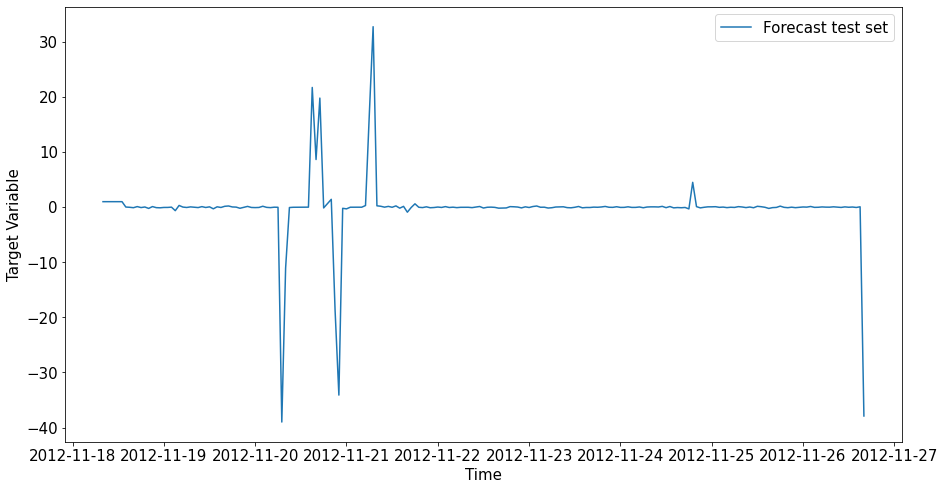

In [28]:
test['SampleTimeUTC']=pd.to_datetime(test['SampleTimeUTC'])
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 15})

# plot the forecasted values against the real values
plt.plot(test['SampleTimeUTC'], test['Pred_predicted'], label='Forecast test set')

plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

In [29]:
test.rename(columns={'Pred_predicted' : 'inj_diff'})['inj_diff'].to_csv('./output/y_test_predictions.csv',index=False)